<td>
<a href="https://colab.research.google.com/github/raoulg/MADS-DAV/blob/main/notebooks/06.2-modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
</td>

In [2]:
from pathlib import Path

import pandas as pd
import requests
import seaborn as sns
from loguru import logger

This notebook is an implementation of the approach described in this [essay](https://www.orphanalytics.com/en/news/whitepaper202012/OrphAnalyticsQAnon2020.pdf) and written about [here](https://www.prnewswire.com/news-releases/qanon-is-two-different-people-shows-machine-learning-analysis-from-orphanalytics-301192981.html).

It analyzes the posts of QAnon, and concludes that the messages are probably written by two persons instead of one.

From the last link:
>  QAnon has spread conspiracy theories to an unprecedentedly large audience. Its thousands of online messages have popularized narratives such as the existence of a child-trafficking deep state. Recently, it inspired a series of violent attacks and was listed as a terrorist threat by the FBI. The Swiss company OrphAnalytics just published an analysis of all messages posted by Q. Its patented technology aims at identifying authors of written documents. It has found two individual signals within the corpus of Q messages. Its new study contributes to revealing the origins and the persons behind one of the most impactful conspiracy theories in recent times.

We will replicate their analysis with "patented technoloy" with a simple sklearn approach.

In [3]:
datadir = Path.home() / ".cache/mads_datasets/qanon"
if not datadir.exists():
    datadir.mkdir(parents=True)

datafile = datadir / "posts.json"
if not datafile.exists():
    logger.info("Downloading QAnon data")
    url = "https://raw.githubusercontent.com/jkingsman/JSON-QAnon/main/posts.json"
    response = requests.get(url, timeout=10)
    with datafile.open("wb") as f:
        f.write(response.content)
else:
    logger.info(f"QAnon data already downloaded at {datafile}")

2025-10-07 18:59:22.897 | INFO     | __main__:<module>:7 - Downloading QAnon data


On Linux and macOS, the default encoding is typically UTF-8.
On Windows, the default encoding is not UTF-8 but rather a locale-specific encoding, often CP1252 or similar. Because, why not use your own proprietary encoding, just to be backwards compatible, even though the rest of the world uses something different?

If you are running this code on a windows machine, you will need to specify the encoding as 'utf-8', like I did below:

In [4]:
import json

from pandas import json_normalize

with datafile.open(encoding="utf-8") as f:
    df = json_normalize(json.load(f)["posts"], sep="_")

In [5]:
df.dtypes

text                          object
referenced_posts              object
post_metadata_author          object
post_metadata_source_board    object
post_metadata_source_site     object
post_metadata_time             int64
post_metadata_id               int64
post_metadata_author_id       object
images                        object
post_metadata_tripcode        object
post_metadata_source_link     object
dtype: object

## Clean up the timestamps

The text describes they used the analysis from [this](https://www.businessinsider.com/every-qanon-message-q-drop-analyzed-2020-10?international=true&r=US&IR=T) businessinsider article to bin the timeseries.

<img src="../img/Qanon.png" width=450 height=400 />

These dates are hardcoded in the bin_time method.

In [6]:
df["time"] = df["post_metadata_time"].apply(pd.to_datetime, unit="s")

In [7]:
from datetime import datetime


def bin_time(time) -> int:
    if time < datetime(2017, 12, 1):
        return 0
    elif time < datetime(2018, 1, 6):
        return 1
    elif time < datetime(2018, 8, 10):
        return 2
    elif time < datetime(2019, 8, 1):
        return 3
    else:
        return 4


df["bintime"] = df["time"].apply(lambda x: bin_time(x))

In [8]:
from datetime import UTC

datetime(2017, 12, 1, tzinfo=UTC)

datetime.datetime(2017, 12, 1, 0, 0, tzinfo=datetime.timezone.utc)

In [9]:
df["bintime"].value_counts()

bintime
3    1743
4    1398
2    1359
0     239
1     227
Name: count, dtype: int64

Let's clean up the text some more. We will replace linebreaks ("\n") with spaces, remove urls and set everything to lowercase.

In [10]:
import re


def remove_url(text):
    return re.sub(r"^https?:\/\/.*[\r\n]*", "", text)


df["text"] = df["text"].apply(lambda x: str(x).replace("\n", " "))
df["text"] = df["text"].apply(lambda x: remove_url(x))
df["text"] = df["text"].apply(lambda x: x.lower())

Now, we count every text and filter chuncks with size below 50.

In [11]:
df["size"] = df["text"].apply(lambda x: len(str(x)))
df = df[df["size"] > 50]
df.reset_index(inplace=True, drop=True)

The paper describes batching all the text into chunks of 7500 characters. We can obtain sort of the same by splitting the text up into 100 batches, 7.7k each.

In [12]:
def batch_seq(text, k):
    longseq = " ".join(text)
    n = int(len(longseq) / k)
    parts = [longseq[i : i + n] for i in range(0, len(longseq), n)]
    return parts, n


z = 100
parts, n = batch_seq(df["text"], k=z)
parts = parts[:-1]
len(parts), n

(100, 7734)

In [13]:
# This gives us groups of 100 posts
df["size"].cumsum() // n

0        0
1        0
2        0
3        0
4        0
        ..
2261    99
2262    99
2263    99
2264    99
2265    99
Name: size, Length: 2266, dtype: int64

In [14]:
# Lets store that group in the dataframe
df.loc[:, "group"] = df["size"].cumsum() // n

The paper uses a ngram with size 3 on characterlevel. We can do that with `CountVectorizer`

How does this work? We will get a matrix with 100 rows (one for every group) and many columns. What are these columns? This are the trigram-counts. Let's see how this works: for example, if I have the string "yellow banana", we get the trigrams: " y", "ye", "el", "ll", "lo", "ow", "w ", " b", "ba", "an", "na", "an", "na". We can see that the trigram "an" appears twice. So, the column "an" will have the value 2, the other trigrams have the value 1. 

In [15]:
from sklearn.feature_extraction.text import CountVectorizer

example = ["yellow banana", "papagena papaya banana"]
vectorizer = CountVectorizer(analyzer="char", ngram_range=(3, 3))
trigram_example = vectorizer.fit_transform(example)
logger.info(f"The trigrams are: {vectorizer.get_feature_names_out()}")
logger.info(f"Shape of the trigram matrix: {trigram_example.shape}")
trigram_example.toarray()

2025-10-07 19:01:01.718 | INFO     | __main__:<module>:6 - The trigrams are: [' ba' ' pa' 'a b' 'a p' 'age' 'ana' 'apa' 'aya' 'ban' 'ell' 'ena' 'gen'
 'llo' 'low' 'na ' 'nan' 'ow ' 'pag' 'pap' 'pay' 'w b' 'ya ' 'yel']
2025-10-07 19:01:01.720 | INFO     | __main__:<module>:7 - Shape of the trigram matrix: (2, 23)


array([[1, 0, 0, 0, 0, 2, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0,
        1],
       [1, 1, 1, 1, 1, 2, 2, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 2, 1, 0, 1,
        0]])

In this example, we see the model counted 23 different trigrams.

Now let's proceed to do the same with our text.

In [16]:
import numpy as np

vectorizer = CountVectorizer(analyzer="char", ngram_range=(3, 3))
X = vectorizer.fit_transform(parts)
X = np.asarray(X.todense())
X.shape

(100, 23075)

You can see we found 23074 different trigrams in our text.

We can now calculates the pairwise manhattan distances. That way, we get an idea how how different every chunk is, when compared to all other chunks, in terms of the ngrams. If the vectors are similar, the distance is zero, if they are very different, the distance is high.

This will give us a 100x100 matrix with the distances, for every vector the distance to all other vectors.

In [17]:
from sklearn.metrics.pairwise import manhattan_distances

distance = manhattan_distances(X, X)
distance.shape, type(distance)

((100, 100), numpy.ndarray)

To handle the labels, we make integers of the labels.

In [18]:
labels = df["post_metadata_source_site"].unique()
mapping = {labels[i]: i for i in range(3)}
df["source"] = df["post_metadata_source_site"].apply(lambda x: mapping[x])
source_names = {v: k for k, v in mapping.items()}
source_names

{0: '4ch', 1: '8ch', 2: '8kun'}

In [19]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
model = pca.fit_transform(distance)

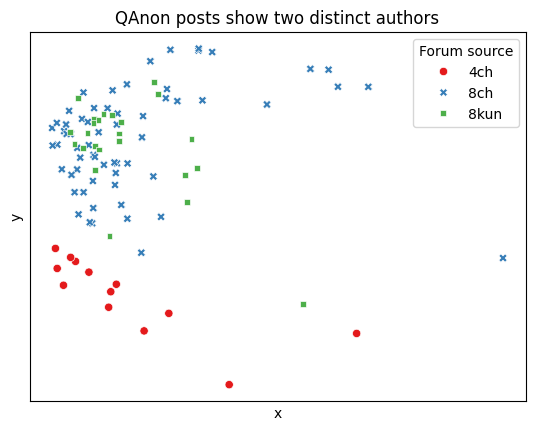

In [20]:
import matplotlib.pyplot as plt

sourcemean = np.round(df.groupby("group").source.mean()).values.reshape(-1, 1)
timemean = np.round(df.groupby("group").bintime.mean()).values.reshape(-1, 1)
p = pd.DataFrame(
    np.concatenate([model, sourcemean, timemean], axis=1),
    columns=["x", "y", "source", "time"],
).reset_index()
p["source"] = p["source"].map(source_names)
sns.scatterplot(data=p, x="x", y="y", hue="source", style="source", palette="Set1")
plt.yticks([])
plt.xticks([])
plt.title("QAnon posts show two distinct authors")
plt.legend(title="Forum source")

This reproduces the main conclusion, that the red source is not overlapping with the other two sources.

Of course, this tells you nothing about how high the chance is, that this is actually caused by having two authors, or by somehow changing the writing style.

For that, we would need access to how likely it is that the writing style changes this much.

However, we still have reproduced their "patented technology" with a few lines of code.
Let's wrap it into a class:

2025-10-07 19:02:10.784 | INFO     | wa_analyzer.model:batch_seq:26 - Splitting text into 100 parts of 7734 characters each
2025-10-07 19:02:10.787 | INFO     | wa_analyzer.model:batch_seq:29 - Removing 1 parts
2025-10-07 19:02:11.085 | INFO     | wa_analyzer.model:fit:35 - Vectorized text into shape (100, 23075)
2025-10-07 19:02:11.253 | INFO     | wa_analyzer.model:reduce_dims:42 - Using PCA


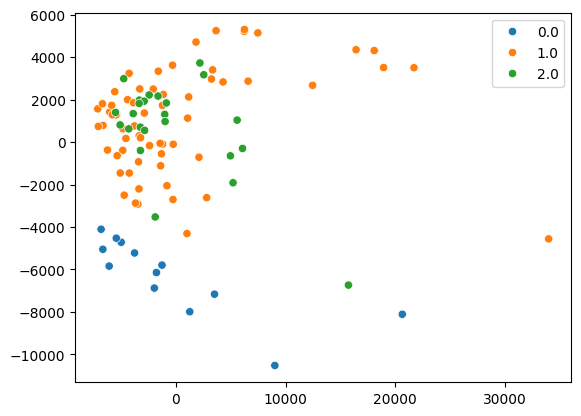

In [21]:
import sys

sys.path.insert(0, "..")

from wa_analyzer.model import TextClustering

clustering = TextClustering()
labels = sourcemean.flatten().astype(str)
clustering(text=df["text"], k=100, labels=labels, batch=True, method="PCA")

And now lets test it on the whatsapp data:

In [38]:
import tomllib

configfile = Path("../config.toml").resolve()
with configfile.open("rb") as f:
    config = tomllib.load(f)
datafile = (Path("..") / Path(config["processed"]) / config["current_2b"]).resolve()
if not datafile.exists():
    logger.warning("Datafile does not exist. First run src/preprocess.py, and check the timestamp!")
wa_df = pd.read_parquet(datafile)
wa_df.head()

,timestamp,author,message,has_emoji
0,2016-01-04 00:06:00+00:00,Rob Haasbroek,‎Rob Haasbroek heeft deze groep gemaakt,False
1,2016-12-17 10:10:58+00:00,What's up with golf,‎Rob Haasbroek heeft je toegevoegd,False
2,2016-12-17 10:11:30+00:00,What's up with golf,‎Berichten en oproepen worden end-to-end versl...,False
3,2016-12-17 10:11:38+00:00,Rob Haasbroek,Anthony met zijn nieuwe nummer toegevoegd aan ...,False
4,2016-12-17 10:12:17+00:00,Anthony van Tilburg,Super!✅,True


We know the authors, so let's use the labels.

In [39]:
authors = list(np.unique(wa_df.author))

We take a subset of every author, and join their texts.
Obviously, you can only do this if you know the authors, or at least the claimed authors. Concatenating all texts together will make the data useless. 

In [40]:
n = 500
min_parts = 2

corpus = {}
for author in authors:
    subset = wa_df[wa_df.author == author].reset_index()
    longseq = " ".join(subset.message)
    # chunk everything into n-sized parts
    parts = [longseq[i : i + n] for i in range(0, len(longseq), n)]
    # clean urls
    parts = [remove_url(chunk) for chunk in parts]
    # remove double spaces
    parts = [re.sub(" +", " ", chunk) for chunk in parts]
    # keep only parts with more than min_parts
    if len(parts) > min_parts:
        corpus[author] = parts
corpus.keys()

dict_keys(['Anthony van Tilburg', 'Hugo Brouwer', 'Martin Kat', 'Rob Haasbroek', 'Youri Haasbroek'])

2025-10-07 19:20:27.358 | INFO     | wa_analyzer.model:fit:35 - Vectorized text into shape (138, 6291)
2025-10-07 19:20:27.441 | INFO     | wa_analyzer.model:reduce_dims:45 - Using t-SNE


Text(0.5, 1.0, 'Distinct authors in the WhatsApp dataset')

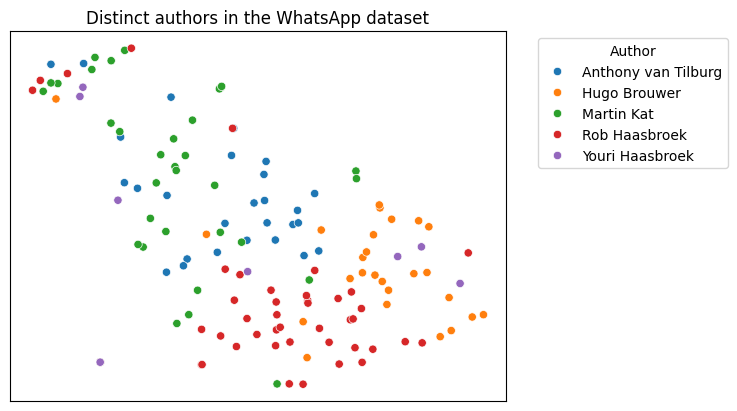

In [41]:
import matplotlib.pyplot as plt

text = [part for text in corpus.values() for part in text]
wa_labels = [k for k, v in corpus.items() for _ in range(len(v))]
# we set batch to false, because we already batched the data
clustering(text=text, k=100, labels=wa_labels, batch=False, method="tSNE")
plt.legend(title="Author", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xticks([])
plt.yticks([])
plt.title("Distinct authors in the WhatsApp dataset")